# Problem description

The project is inspired by CS229 Student Final Project: 
**Tag Prediction from Stack Overflow Questions**, 
Jalal Buckley, Kevin Fuhs, Reid M. Whitaker (<a href="http://cs229.stanford.edu/proj2019spr/poster/78.pdf">poster</a>, <a href="http://cs229.stanford.edu/proj2019spr/report/78.pdf">report</a>)


The task and the data are given in Kaggle competition: <a href="https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/overview">Facebook Recruiting III - Keyword Extraction</a>.

------------------
* **Task description (<a href="https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/overview">Description from competition overview</a>):**


*The task is to predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title.
The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.*

* **Data description (<a href="https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data">Description from competition overview</a>):**

*All of the data is in 2 files: Train and Test.*

*Train.csv contains 4 columns: Id,Title,Body,Tags*

  * *Id - Unique identifier for each question*
  * *Title - The question's title*
  * *Body - The body of the question*
  * *Tags - The tags associated with the question (all lowercase, should not c contain tabs '\t' or ampersands '&')*
  * *Test.csv contains the same columns but without the Tags, which you are to predict.*

*The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).*

------------------

<img src="assets/StackOverflowTags.png"/>

-----------------


This is Multi-label Classification problem (assigns a set of target labels to each instance), with large number of labels.

Below are summarized techniques for solving this problem. Highlighted techniques are used in the project.


Multi-label Classification Solutions:
------
Resources: <a href="https://en.wikipedia.org/wiki/Multi-label_classification">Multi-label classification - Wikipedia</a>, <a href="http://scikit.ml/concepts.html">Relevant Concepts in Multi-Label Classification - Scikit-Multilearn</a>

**Problem transformation methods** 

*Several problem transformation methods exist for multi-label classification, and can be roughly broken down into:*

* *Transformation into binary classification problems:*

  *  <mark>Binary Relevance</mark> (used in our project)
  *  <mark>Classifier Chains</mark> (used in our project)

* *Transformation into multi-class classification problems:*

  *  Using The Label Powerset (not applicable for this task due to the large number of tags)

* *Ensemble methods:*

    * Ensemble of multi-label classifiers predicting a single class and predictions are then combined usually by voting scheme.

**Adapted algorithms**
* k-nearest neighbors
* Decision Trees
* <mark>Neural Networks</mark> (used in our project)

------------




# Data analysis 

## Necessary downloads and library imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = '/content/drive/My Drive/Colab Notebooks/MATF_ML_project/'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
from wordcloud import WordCloud

## Load data

We will turn off detection of missing value markers due to the presence of "null" tags that are otherwise recognised as NA values. There are no true NA values in data.

In [4]:
data = pd.read_csv(project_path + 'data/Train.csv', 
                   na_filter=False, nrows=100000)

In [5]:
data.head(10)

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents
5,6,setting proxy in active directory environment,<p>I am using a machine on which active direct...,proxy active-directory jmeter
6,7,How to draw barplot in this way with Coreplot,<p>My image is cannot post so the link is my ...,core-plot
7,8,How to fetch an XML feed using asp.net,<p>I've decided to convert a Windows Phone 7 a...,c# asp.net windows-phone-7
8,9,.NET library for generating javascript?,<p>Do you know of a .NET library for generatin...,.net javascript code-generation
9,10,"SQL Server : procedure call, inline concatenat...",<p>I'm using SQL Server 2008 R2 and was wonder...,sql variables parameters procedure calls


In [6]:
data.shape

(100000, 4)

In [7]:
print("Example:")
print("========")
print("Tags:\n ", data['Tags'][0])
print("Title:\n ", data['Title'][0])
print("Body:\n ", data['Body'][0])

Example:
Tags:
  php image-processing file-upload upload mime-types
Title:
  How to check if an uploaded file is an image without mime type?
Body:
  <p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or another file. The problem is that I'm using Uploadify to upload the files, which changes the mime type and gives a 'text/octal' or something as the mime type, no matter which file type you upload.</p>

<p>Is there a way to check if the uploaded file is an image apart from checking the file extension using PHP?</p>



## Analysis of Tags

We will print the the number of times tags appeared and the total number of different tags.

In [8]:
tags_per_question = list(map(lambda tags: tags.split(' '), data["Tags"]))
all_tags = [item for sublist in tags_per_question for item in sublist]
all_tags = np.array(all_tags)

In [9]:
unique, counts = np.unique(all_tags, return_counts=True)
tag_counts = dict(zip(unique, counts))

In [10]:
tags = pd.DataFrame.from_dict(tag_counts, orient='index',
                       columns=['counts'])

In [11]:
tags.head(10)

,counts
.a,2
.bash-profile,1
.class-file,1
.each,6
.emf,2
.hgtags,2
.htaccess,333
.htpasswd,1
.mov,1
.net,2685


In [12]:
print('Total number of tags is', tags.shape[0])

Total number of tags is 18448


### Tags distribution

In [13]:
tags_sorted = tags.sort_values(['counts'], ascending=False)

In [14]:
tag_counts = tags_sorted['counts']

In [15]:
tag_cumsum = np.cumsum(tag_counts)

In [16]:
N_tags = 100 # first N tags

In [17]:
ids_quantile = [tag_cumsum[tag_cumsum < perc * tag_cumsum[N_tags]].shape[0] 
                for perc in [0, 0.25, 0.50, 0.75, 1] ]
labels = ['0%', '25%', '50%', '75%', '100%']

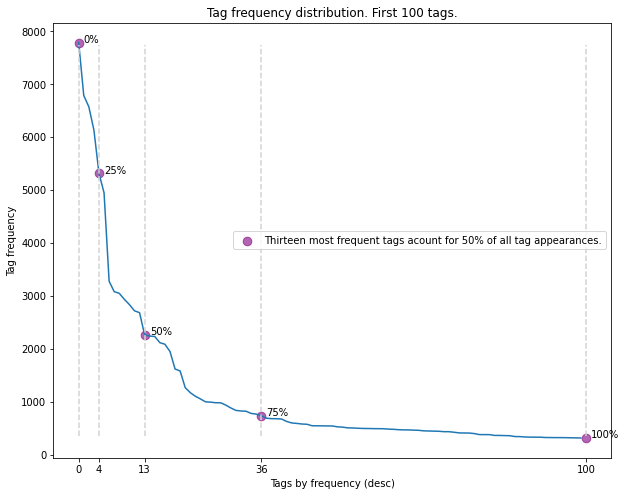

In [44]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(N_tags), tag_counts[:N_tags])
plt.title("Tag frequency distribution. First " + str(N_tags) + " tags.")
plt.xlabel("Tags by frequency (desc)")
plt.ylabel("Tag frequency")

plt.xticks(ids_quantile)
plt.scatter(ids_quantile, tag_counts[ids_quantile], color='purple', s=75,
            alpha=0.6, label='Thirteen most frequent tags acount for 50% of all tag appearances.');
for i in range(len(labels)):
    plt.axvline(x=ids_quantile[i],  ymin=0.05, ymax=0.95, color='lightgrey', linestyle='--')
    plt.annotate(labels[i], (ids_quantile[i] + 1, tag_counts[ids_quantile[i]] + 1))
    
plt.legend(loc='right')
plt.show()

In [45]:
print("The most frequent tag is", "'" +  tags_sorted.index[0] + "'", 
      "\t\tnumber of occurrences: ", tag_counts[0])
print("10th most frequent tag is", "'" +  tags_sorted.index[10] + "'", 
      "\tnumber of occurrences: ", tag_counts[10])
print("25th most frequent tag is", "'" +  tags_sorted.index[25] + "'", 
      "\tnumber of occurrences: ", tag_counts[25])

The most frequent tag is 'c#' 		number of occurrences:  7786
10th most frequent tag is 'mysql' 	number of occurrences:  2837
25th most frequent tag is 'ajax' 	number of occurrences:  1000


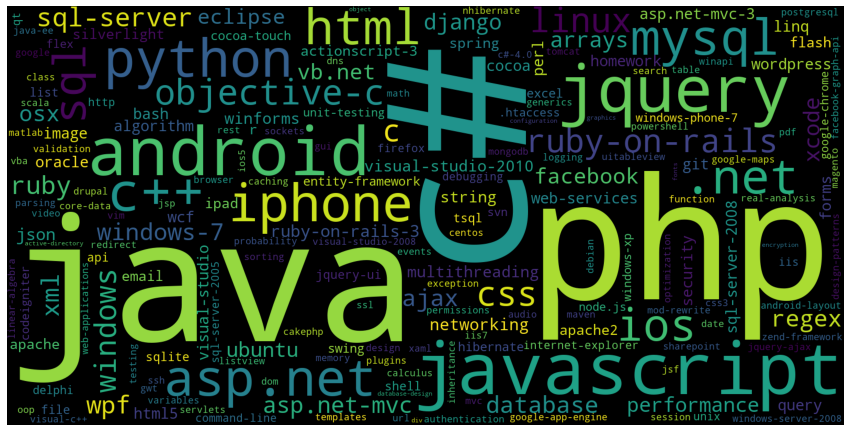

In [20]:
wordcloud = WordCloud(background_color='black',
         width = 1600,
         height = 800).generate_from_frequencies(tag_counts)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Tags per question

In [21]:
counts_per_question = [len(tags) for tags in tags_per_question]
# counts_per_question

In [22]:
avg_tags_per_q = np.average(counts_per_question)
min_tags_per_q = np.min(counts_per_question)
max_tags_per_q = np.max(counts_per_question)

In [23]:
print("Average number of tags per question: %.2f"%avg_tags_per_q)
print("Minimum number of tags per question:", min_tags_per_q)
print("Maximum number of tags per question:", max_tags_per_q)

Average number of tags per question: 2.88
Minimum number of tags per question: 1
Maximum number of tags per question: 5


In [24]:
nums_of_q = [counts_per_question.count(i) for i in range(1, max_tags_per_q+1)]
# nums_of_q

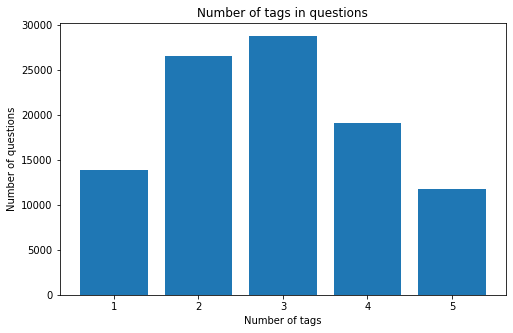

In [25]:
plt.figure(figsize=(8,5))
plt.bar(np.arange(1, max_tags_per_q+1), nums_of_q)
plt.title("Number of tags in questions")
plt.xlabel("Number of tags")
plt.ylabel("Number of questions")
plt.show()

### Combinations of Tags

In [26]:
data["Tags"]

0        php image-processing file-upload upload mime-t...
1                                                  firefox
2                                r matlab machine-learning
3                                          c# url encoding
4                                php api file-get-contents
                               ...                        
99995                                    wordpress fgetpos
99996    automation microsoft-powerpoint microsoft-powe...
99997                 functional-analysis fourier-analysis
99998                                     assembly x86 dos
99999                                  c# iphone monotouch
Name: Tags, Length: 100000, dtype: object

In [27]:
tag_combinations = data['Tags']

In [28]:
unique_tag_combinations = tag_combinations.unique()

In [29]:
unique_tag_combinations

array(['php image-processing file-upload upload mime-types', 'firefox',
       'r matlab machine-learning', ...,
       'automation microsoft-powerpoint microsoft-powerpoint-2010 query',
       'assembly x86 dos', 'c# iphone monotouch'], dtype=object)

In [30]:
tag_combinations.shape

(100000,)

In [31]:
print("Number of unique tag combinations is ", unique_tag_combinations.shape[0])

Number of unique tag combinations is  73228


## Anaysis of Questions

### Duplicates in data

In [32]:
print("Unique titles:", data['Title'].unique().shape[0])
print("All titles:", data['Title'].shape[0])
print("Unique bodies:", data['Body'].unique().shape[0])
print("All bodies:", data['Body'].shape[0])

Unique titles: 99405
All titles: 100000
Unique bodies: 99419
All bodies: 100000


### Question structure

In [33]:
avg_title_len = np.average([len(title.split(' ')) for title in data['Title']])
print("Average number of words per Question Title: ", avg_title_len)
avg_body_len = np.average([len(body.split(' ')) for body in data['Body']])
print("Average number of words per Question Body: ", avg_body_len)

Average number of words per Question Title:  8.33559
Average number of words per Question Body:  184.4546
